# File and libraries

In [44]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_msg_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Ecom Multichannel messages"

# DSLabs functions

In [45]:
%run "scripts/dslabs_functions.py"


# Data functions

In [46]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [47]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='is_clicked'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27258 entries, 0 to 27257
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_name                       27258 non-null  float64
 1   device_category                  27258 non-null  float64
 2   device_mobile_brand_name         27258 non-null  float64
 3   device_mobile_model_name         27258 non-null  float64
 4   device_operating_system          27258 non-null  float64
 5   device_operating_system_version  27258 non-null  float64
 6   device_language                  27258 non-null  float64
 7   device_web_info_browser          27258 non-null  float64
 8   device_web_info_browser_version  27258 non-null  float64
 9   geo_region                       27258 non-null  float64
 10  geo_city                         27258 non-null  float64
 11  traffic_source_medium            27258 non-null  float64
 12  traffic_source_source  

# Distribution Check

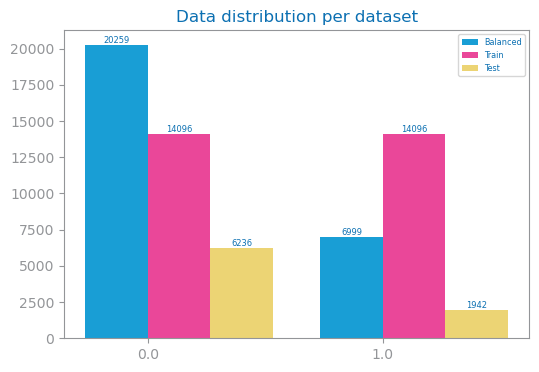

In [48]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation Prep

In [49]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=28192 Test#=8178
Labels=[0.0, 1.0]


In [50]:
max_trees_eval=1500
max_trees_eval_lag=250

# f2 Model Evaluation

## f2 study

RF best for 750 trees (d=2 and f=0.7)


<Figure size 640x480 with 0 Axes>

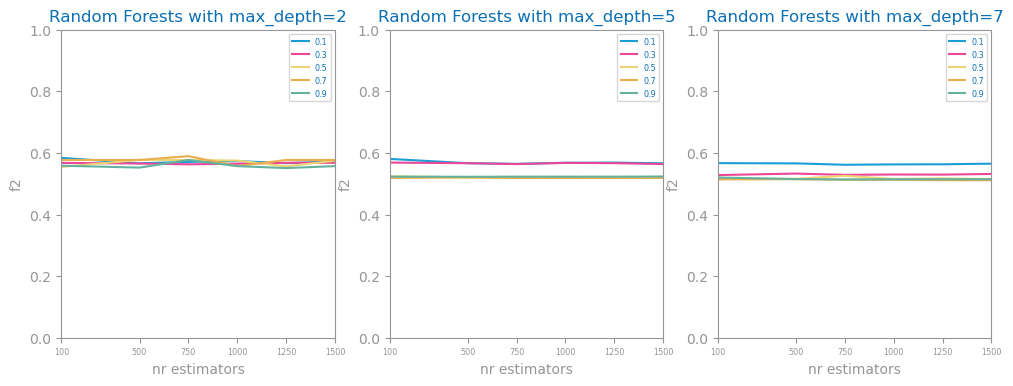

In [51]:

figure()


best_model_f2, f2_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
)

savefig(f'images/{file_tag}_rf_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

<Figure size 640x480 with 0 Axes>

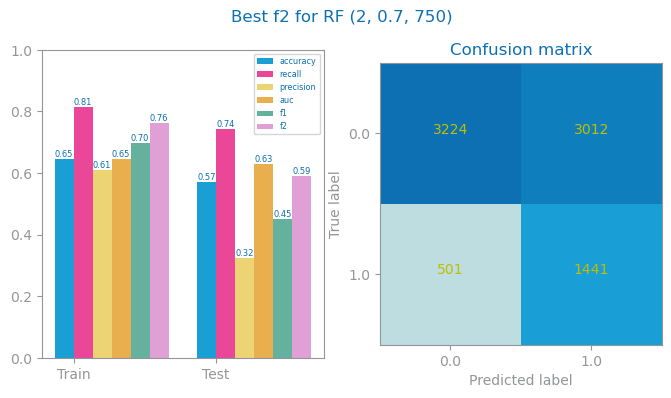

In [52]:
if evaluate == True:
    prd_trn: array = best_model_f2.predict(trnX)
    prd_tst: array = best_model_f2.predict(tstX)
    figure()
    plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_rf_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
    show()

## f2 Variables importance


1. event_name (0.40444222262662743)
2. traffic_source_source (0.3160580142538148)
3. traffic_source_medium (0.1077724409589075)
4. page_path_level_2 (0.053860326647831434)
5. page_path_level_1 (0.0517026858986604)
6. engagement_time_msec (0.0462965531892936)
7. page_path_level_3 (0.015485276252826799)
8. geo_city (0.0017357230808058381)
9. session_engaged (0.0014881716695232432)
10. day_cos (0.00038403758450349665)
11. day_of_year (0.0003700047537281421)
12. geo_region (0.0002517746733730083)
13. week_number (6.263084661504521e-05)
14. path_length (3.499543989326692e-05)
15. day_sin (2.941304139105325e-05)
16. device_mobile_model_name (2.5729082204982903e-05)
17. local_minute_cos (0.0)
18. week_of_month_nr_cos (0.0)
19. device_category (0.0)
20. device_mobile_brand_name (0.0)
21. device_operating_system (0.0)
22. device_operating_system_version (0.0)
23. device_language (0.0)
24. device_web_info_browser (0.0)
25. device_web_info_browser_version (0.0)
26. quarter (0.0)
27. year (0.0)
28

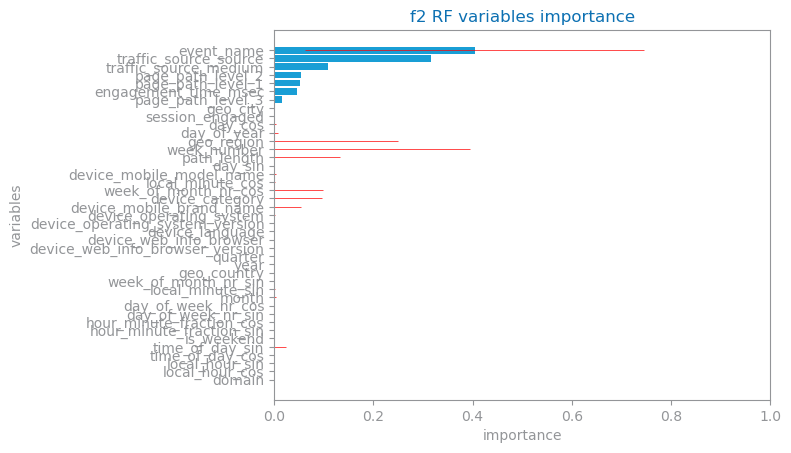

In [53]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_f2.estimators_], axis=0)
)
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{f2_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

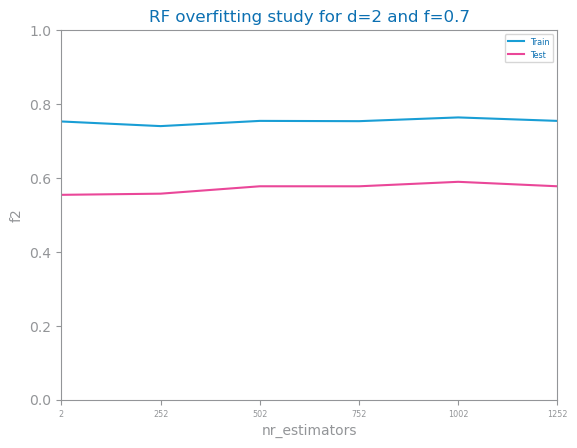

In [54]:
d_max: int = f2_params["params"][0]
feat: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_rf_{eval_metric}_overfitting.png")

# Precision Model Evaluation

## precision study

In [ ]:

figure()

best_model_prec, prec_params = random_forests_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='precision',
)

savefig(f'images/{file_tag}_rf_{prec_params["metric"]}_study.png')
show()

## precision best model performance

<Figure size 640x480 with 0 Axes>

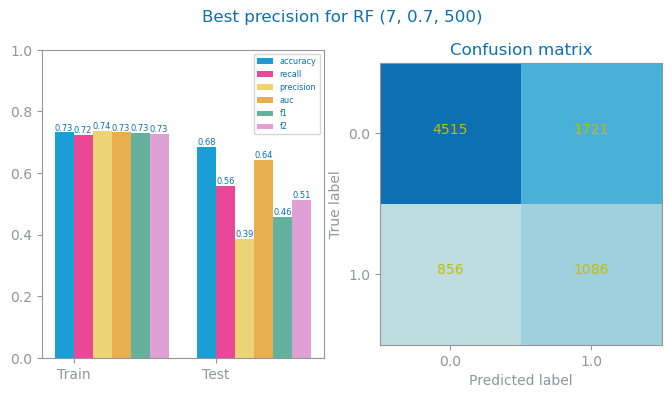

In [39]:
if evaluate == True:
    prd_trn: array = best_model_prec.predict(trnX)
    prd_tst: array = best_model_prec.predict(tstX)
    figure()
    plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_rf_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
    show()

## precision variables importance

1. event_name (0.3708896763816485)
2. traffic_source_source (0.24309332343876128)
3. traffic_source_medium (0.10574164000832037)
4. page_path_level_3 (0.0490612185710355)
5. engagement_time_msec (0.03260003597995494)
6. page_path_level_2 (0.032547295038883435)
7. page_path_level_1 (0.025730871142619252)
8. path_length (0.023017329956882625)
9. geo_city (0.019535164743643228)
10. hour_minute_fraction_cos (0.010785451842135446)
11. day_of_year (0.010195761275220757)
12. day_sin (0.00753220809607679)
13. hour_minute_fraction_sin (0.007200962948234798)
14. geo_region (0.006481178297176842)
15. session_engaged (0.005399524220467812)
16. day_cos (0.004420545631716898)
17. device_web_info_browser_version (0.0043779481368517136)
18. device_operating_system_version (0.004032027247550577)
19. local_minute_cos (0.003802795390757762)
20. device_language (0.0034824763609260017)
21. local_minute_sin (0.0034453521604562633)
22. local_hour_sin (0.002874844741744919)
23. day_of_week_nr_sin (0.002540276

<Axes: title={'center': 'RF variables importance'}, xlabel='importance', ylabel='variables'>

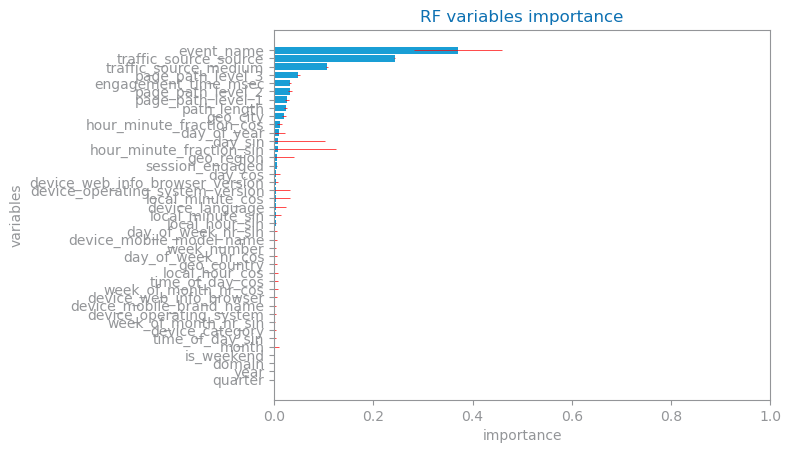

In [41]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

stdevs: list[float] = list(
    std([tree.feature_importances_ for tree in best_model_prec.estimators_], axis=0)
)
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title=f"{prec_params["metric"]} RF variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)

## precision overfitting

<Axes: title={'center': 'RF overfitting study for d=7 and f=0.7'}, xlabel='nr_estimators', ylabel='precision'>

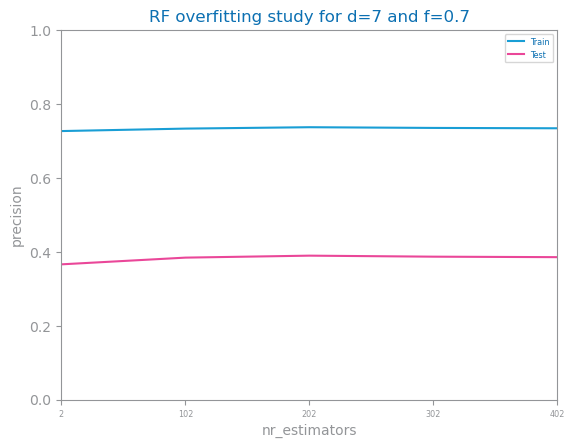

In [43]:
d_max: int = prec_params["params"][0]
feat: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params["metric"]

for n in nr_estimators:
    clf = RandomForestClassifier(n_estimators=n, max_depth=d_max, max_features=feat)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"RF overfitting study for d={d_max} and f={feat}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
